# Basic workflow

This page demonstrates how to perform basic operations in Atomica. First, we will set up the notebook environment - the commands below are typically not required in user scripts:

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('..')

To start with, import Atomica itself. It is often also useful to import `numpy` and `matplotlib`

In [2]:
import atomica as at
import numpy as np
import matplotlib.pyplot as plt

## Starting an application

The first step in starting a new application is to write a Framework file. This can be done by copying one of the templates in the `atomica/library` folder (either `framework_template.xlsx` or `framework_template_advanced.xlsx`) and implementing your model. Further guidance on this is provided separately in the framework documentation. 

After writing the Framework, the next step is to generate a databook. This is performed in three steps

1. Load the framework into a `ProjectFramework` Python instance
2. Use the framework to make a new `ProjectData` instance
3. Save the `ProjectData` instance to a spreadsheet

In this example, we will load an existing framework from the library. You can use `at.LIBRARY_PATH` to refer to the folder containing the library Excel files shipped with Atomica:

In [3]:
F = at.ProjectFramework(at.LIBRARY_PATH / 'tb_framework.xlsx') # Load the Framework
D = at.ProjectData.new(F,pops=2, tvec=np.arange(2000,2018), transfers=0) 
D.save('new_databook.xlsx')

Object saved to /home/vsts/work/1/s/docs/examples/new_databook.xlsx.


The `ProjectData` class in Python can be thought of as an equivalent representation of the databook - you can edit the databook in Excel, which will result in changes to the `ProjectData` variable when the spreadsheet is loaded, and you can modify the `ProjectData` in Python and then write a modified spreadsheet. `ProjectData` has a number of methods that you can use to modify the databook, to do things like

- Add or remove populations
- Change the time span of the databook

To perform these operations, you can load in a databook using `ProjectData.from_spreadsheet()`. This lets you load in a databook given a particular framework. It is not required that the databook be completed prior to loading - you only need to complete the databook in its entirity if you want to use the databook in a project. So for example, to add an additional population and a transfer to this newly created databook, we could use:

In [4]:
D = at.ProjectData.from_spreadsheet('new_databook.xlsx', framework=F)
D.add_pop('pris','Prisoners')
D.add_transfer('aging','Aging')
D.save('new_databook_2.xlsx')

Object saved to /home/vsts/work/1/s/docs/examples/new_databook_2.xlsx.


## Creating a project

Once you have completed the framework file and databook, you can create a project that can be used to run simulations and analyses. To do this, simply create a `Project` instance, passing in the file names for the framework and databook. Here we will use a pre-filled databook from the library:

In [5]:
P = at.Project(framework=at.LIBRARY_PATH / 'tb_framework.xlsx', databook=at.LIBRARY_PATH / 'tb_databook.xlsx')

Elapsed time for running "default": 0.967s


When you create a project, a default simulation is automatically run. You can subsequently run simulations using `P.run_sim()`

In [6]:
res = P.run_sim(parset='default', result_name='Default parset')
P.results.keys()

Elapsed time for running "default": 0.882s


['parset_default']

When you run a simulation, by default it is automatically copied into the project, as well as being returned. Specifying the result name is optional, but recommended because it helps to keep track of the simulations when comparing and plotting them. We can now plot the result to show the compartment sizes:

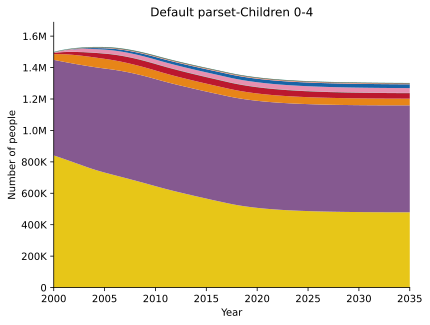

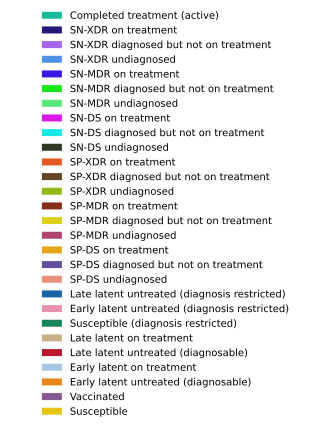

In [7]:
d = at.PlotData(res,pops='0-4',project=P)
at.plot_series(d,plot_type='stacked', data=P.data, legend_mode='separate');

For full details on plotting, please refer to the full plotting documentation [here](https://atomica.tools/docs/master/examples/Plotting.html).

## Calibrating the model

Model calibration can be performed in one of two ways - either manually, or automatically

### Manual calibration

Manual calibration of the model proceeds in three steps

1. Make a new ParameterSet (e.g., by copying an existing one)
2. Modify the calibration scale factors in that ParameterSet
3. Run a simulation using the new parameter set

The commands to do this are shown below, for an example where the force of infection has been decreased:

Elapsed time for running "default": 1.03s


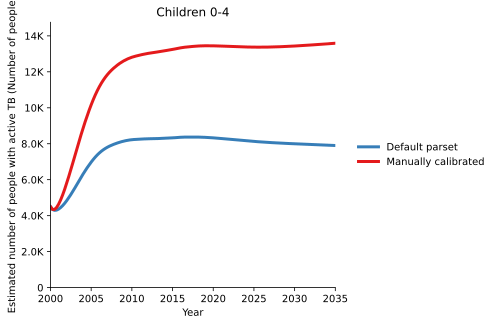

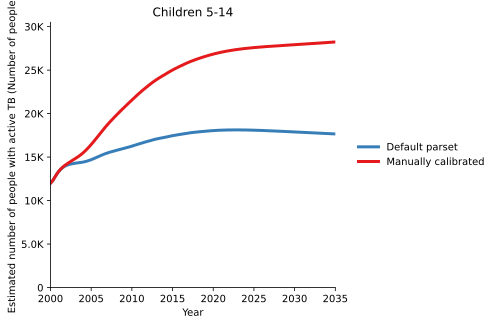

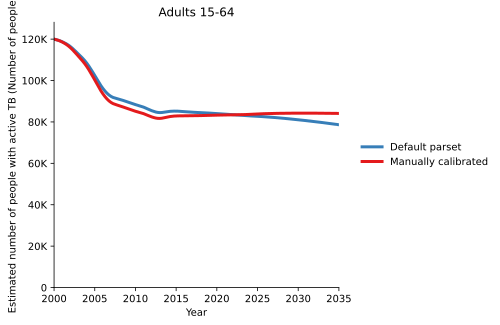

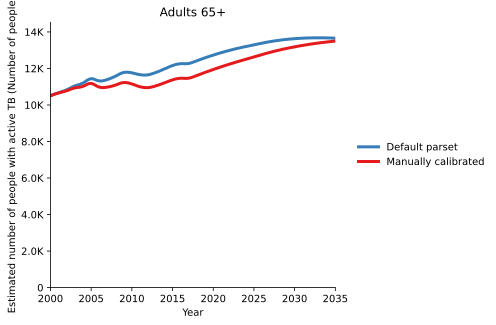

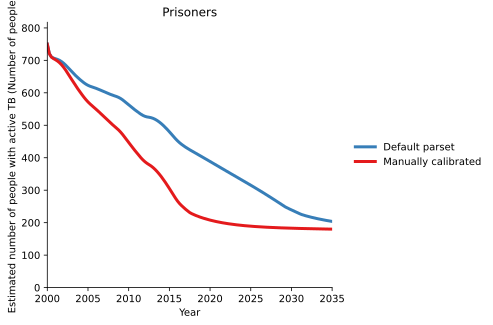

In [8]:
new_parset = P.parsets.copy('default','manually_calibrated')
new_parset.pars['foi_out'].meta_y_factor = 0.8 # Decrease infectiousness of all populations
new_parset.pars['foi_in'].y_factor['0-4'] = 2.0 # Increase susceptibility of young children
res_manually_calibrated = P.run_sim(parset='manually_calibrated', result_name='Manually calibrated')
d = at.PlotData([res,res_manually_calibrated],outputs='ac_inf',project=P)
at.plot_series(d, axis='results');

### Automatic calibration

To perform an automatic calibration, simply use `P.calibrate()` specifying the amount of time to run the calibration for, and the name of the new calibrated parset to create.

In [9]:
P.calibrate(max_time=10, parset='default', new_name="auto_calibrated", save_to_project=True);

ASD: Launching with random seed None


Elapsed time for running "default": 0.605s


Elapsed time for running "default": 0.775s


    step=1 choice=81, par=81, pm=0.0, origval=1.0, newval=1.1
     step 1 (0.8 s) -- (orig:10.14 | best:10.14 | new:10.19 | diff:0.05875)


Elapsed time for running "default": 0.611s


    step=2 choice=221, par=91, pm=1.0, origval=1.0, newval=0.9
     step 2 (1.4 s) -- (orig:10.14 | best:10.14 | new:10.14 | diff:0)


Elapsed time for running "default": 0.611s


    step=3 choice=232, par=102, pm=1.0, origval=1.0, newval=0.9
     step 3 (2.0 s) -- (orig:10.14 | best:10.14 | new:10.14 | diff:0)


Elapsed time for running "default": 0.606s


    step=4 choice=249, par=119, pm=1.0, origval=1.0, newval=0.9
     step 4 (2.6 s) -- (orig:10.14 | best:10.14 | new:10.24 | diff:0.1072)


Elapsed time for running "default": 0.633s


    step=5 choice=9, par=9, pm=0.0, origval=1.0, newval=1.1
     step 5 (3.3 s) -- (orig:10.14 | best:10.14 | new:10.18 | diff:0.04397)


Elapsed time for running "default": 0.827s


    step=6 choice=192, par=62, pm=1.0, origval=1.0, newval=0.9
     step 6 (4.1 s) ++ (orig:10.14 | best:10.14 | new:10.14 | diff:-0.000005557)


Elapsed time for running "default": 0.605s


    step=7 choice=118, par=118, pm=0.0, origval=1.0, newval=1.1
     step 7 (4.7 s) -- (orig:10.14 | best:10.14 | new:10.37 | diff:0.2314)


Elapsed time for running "default": 0.640s


    step=8 choice=45, par=45, pm=0.0, origval=1.0, newval=1.1
     step 8 (5.4 s) ++ (orig:10.14 | best:10.14 | new:10.13 | diff:-0.008828)


Elapsed time for running "default": 0.604s


    step=9 choice=164, par=34, pm=1.0, origval=1.0, newval=0.9
     step 9 (6.0 s) -- (orig:10.14 | best:10.13 | new:10.13 | diff:0.001524)


Elapsed time for running "default": 0.607s


    step=10 choice=91, par=91, pm=0.0, origval=1.0, newval=1.1
     step 10 (6.6 s) -- (orig:10.14 | best:10.13 | new:10.13 | diff:0)


Elapsed time for running "default": 0.861s


    step=11 choice=54, par=54, pm=0.0, origval=1.0, newval=1.1
     step 11 (7.5 s) -- (orig:10.14 | best:10.13 | new:10.13 | diff:0.0000006326)


Elapsed time for running "default": 0.716s


    step=12 choice=224, par=94, pm=1.0, origval=1.0, newval=0.9
     step 12 (8.2 s) -- (orig:10.14 | best:10.13 | new:10.13 | diff:0)


Elapsed time for running "default": 0.638s


    step=13 choice=4, par=4, pm=0.0, origval=1.0, newval=1.1
     step 13 (8.8 s) ++ (orig:10.14 | best:10.13 | new:10.04 | diff:-0.08561)


Elapsed time for running "default": 0.614s


    step=14 choice=21, par=21, pm=0.0, origval=1.0, newval=1.1
     step 14 (9.5 s) -- (orig:10.14 | best:10.04 | new:10.05 | diff:0.005653)


Elapsed time for running "default": 0.602s


    step=15 choice=119, par=119, pm=0.0, origval=1.0, newval=1.1
     step 15 (10.1 s) ++ (orig:10.14 | best:10.04 | new:9.937 | diff:-0.1050)
===  Time limit reached (10.06 > 10.00) (15 steps, orig: 10.14 | best: 9.937 | ratio: 0.9803217391882466) ===


You can then run a simulation with the calibrated parset by passing the name of the new parset to `run_sim`

In [10]:
res_auto_calibrated = P.run_sim(parset='auto_calibrated',result_name='Automatically calibrated')

Elapsed time for running "default": 1.18s


## Adding programs

The programs system allows parameter values to be overwritten based on spending on a set of programs. To get started, you will first need a program spreadsheet (progbook). The progbook is specific to a framework and a databook, because it refers to both the compartments and parameters of the model (from the framework) as well as the populations (from the databook). 

You can make a new progbook using the `.make_progbook()` method of the project:

In [11]:
P.make_progbook(progbook_path='example_progbook.xlsx', progs=4, data_start=2014, data_end=2018)

Object saved to /home/vsts/work/1/s/docs/examples/example_progbook.xlsx.


'/home/vsts/work/1/s/docs/examples/example_progbook.xlsx'

After filling out the progbook, you can load it into the project using the `.load_progbook()` method. Here, we will load in a pre-filled progbook from the library:

In [12]:
P.load_progbook(at.LIBRARY_PATH / 'tb_progbook.xlsx')

[<class 'atomica.programs.ProgramSet'>, <class 'atomica.utils.NamedItem'>]
————————————————————————————————————————————————————————————————————————
Methods:
  _get_code_name()        add_pop()               remove_par()            
  _normalize_inputs()     add_program()           remove_pop()            
  _read_effects()         copy()                  remove_program()        
  _read_spending()        from_spreadsheet()      sample()                
  _read_targeting()       get_alloc()             save()                  
  _write_effects()        get_capacities()        to_spreadsheet()        
  _write_spending()       get_outcomes()          to_workbook()           
  _write_targeting()      get_prop_coverage()     validate()              
  add_comp()              new()                   add_par()               
  remove_comp()           
————————————————————————————————————————————————————————————————————————
      _book: None
   _formats: None
 _pop_types: ['default']
_refere

This progbook has been added to the list of available progsets:

In [13]:
P.progsets.keys()

['default']

Running a simulation with programs requires one additional piece of information - a `ProgramInstructions` instance that specifies

- What years the programs are active
- Any overwrites to spending or coverage

In our case, we might just want to run a simulation with programs starting in 2018, so we can create a `ProgramInstructions` instance accordingly, and then use it to run the simulation:

In [14]:
instructions = at.ProgramInstructions(start_year=2018)
res_progs = P.run_sim(parset='default',progset='default',progset_instructions=instructions)

Elapsed time for running "default": 1.20s


## Reconciliation

Reconciliation is an operation that aims to change the properties of programs (such as their unit costs) such that the program-calculated parameter values optimally match the databook parameter values in the year the programs become active (or some other specified year). The reconciliation operation can therefore be treated as a mapping from one progset to another. To perform reconciliation, use the `reconcile` function directly, passing in:

- the parameter set you want to match
- the program set to modify
- the reconciliation year
- a specification of which aspects of the program set to modify (e.g. unit cost, program outcomes)

The reconcile function returns a new progset, which you can store in the project if desired, or otherwise work with independently:

In [15]:
P.progsets['reconciled'] = at.reconcile(project=P, parset='default', progset='default', reconciliation_year=2018, unit_cost_bounds=0.05)[0]

WARNING {reconciliation.py:243} - Reconcilation when parameter is in number units not fully tested


Program set 'default' will be ignored while running project 'default' due to the absence of program set instructions


Elapsed time for running "default": 1.10s


Reconciling in 2018.00, evaluating from 2018.00 up to 2018.25


ASD: Launching with random seed None
    step=1 choice=5, par=5, pm=0.0, origval=7500.0, newval=7875.0
     step 1 (0.0 s) -- (orig:61.58 | best:61.58 | new:61.68 | diff:0.09877)
    step=2 choice=6, par=6, pm=0.0, origval=10000.0, newval=10500.0
     step 2 (0.0 s) -- (orig:61.58 | best:61.58 | new:61.61 | diff:0.02779)
    step=3 choice=5, par=5, pm=0.0, origval=7500.0, newval=7875.0
     step 3 (0.0 s) -- (orig:61.58 | best:61.58 | new:61.68 | diff:0.09877)
    step=4 choice=12, par=0, pm=1.0, origval=2.5, newval=2.375
     step 4 (0.0 s) ++ (orig:61.58 | best:61.58 | new:61.58 | diff:-0.00002755)
    step=5 choice=3, par=3, pm=0.0, origval=2500.0, newval=2625.0
     step 5 (0.0 s) -- (orig:61.58 | best:61.58 | new:61.59 | diff:0.005385)
    step=6 choice=17, par=5, pm=1.0, origval=7500.0, newval=7125.0
     step 6 (0.0 s) ++ (orig:61.58 | best:61.58 | new:61.50 | diff:-0.08149)
    step=7 choice=18, par=6, pm=1.0, origval=10000.0, newval=9500.0
     step 7 (0.0 s) ++ (orig:61.58 | 

    step=87 choice=5, par=5, pm=0.0, origval=7125.0, newval=7171.875
     step 87 (0.2 s) -- (orig:61.58 | best:61.38 | new:61.39 | diff:0.009000)
    step=88 choice=3, par=3, pm=0.0, origval=2375.0, newval=2382.8125
     step 88 (0.2 s) -- (orig:61.58 | best:61.38 | new:61.38 | diff:0.0003902)
    step=89 choice=8, par=8, pm=0.0, origval=4500.0, newval=4528.125
     step 89 (0.2 s) -- (orig:61.58 | best:61.38 | new:61.38 | diff:0)
    step=90 choice=6, par=6, pm=0.0, origval=9500.0, newval=9531.25
     step 90 (0.2 s) -- (orig:61.58 | best:61.38 | new:61.38 | diff:0.001903)
    step=91 choice=8, par=8, pm=0.0, origval=4500.0, newval=4514.0625
     step 91 (0.2 s) -- (orig:61.58 | best:61.38 | new:61.38 | diff:0)
    step=92 choice=2, par=2, pm=0.0, origval=3800.0, newval=3812.5
     step 92 (0.2 s) -- (orig:61.58 | best:61.38 | new:61.38 | diff:0.000001631)
    step=93 choice=5, par=5, pm=0.0, origval=7125.0, newval=7148.4375
     step 93 (0.2 s) -- (orig:61.58 | best:61.38 | new:61.3

    step=96 choice=7, par=7, pm=0.0, origval=2700.0, newval=2708.4375
     step 96 (0.2 s) -- (orig:61.58 | best:61.38 | new:61.38 | diff:0)
    step=97 choice=11, par=11, pm=0.0, origval=8000.0, newval=8025.0
     step 97 (0.2 s) -- (orig:61.58 | best:61.38 | new:61.38 | diff:0)
    step=98 choice=9, par=9, pm=0.0, origval=17100.0, newval=17156.25
     step 98 (0.2 s) -- (orig:61.58 | best:61.38 | new:61.38 | diff:0.0008633)
    step=99 choice=9, par=9, pm=0.0, origval=17100.0, newval=17128.125
     step 99 (0.2 s) -- (orig:61.58 | best:61.38 | new:61.38 | diff:0.0004323)
    step=100 choice=22, par=10, pm=1.0, origval=5500.0, newval=5482.8125
     step 100 (0.2 s) -- (orig:61.58 | best:61.38 | new:61.38 | diff:0.00001808)


    step=101 choice=5, par=5, pm=0.0, origval=7125.0, newval=7136.71875
     step 101 (0.2 s) -- (orig:61.58 | best:61.38 | new:61.38 | diff:0.002214)
    step=102 choice=0, par=0, pm=0.0, origval=2.375, newval=2.3828125
     step 102 (0.2 s) -- (orig:61.58 | best:61.38 | new:61.38 | diff:0.000001074)
    step=103 choice=0, par=0, pm=0.0, origval=2.375, newval=2.37890625
     step 103 (0.2 s) -- (orig:61.58 | best:61.38 | new:61.38 | diff:0.0000005250)
    step=104 choice=10, par=10, pm=0.0, origval=5500.0, newval=5517.1875
     step 104 (0.2 s) -- (orig:61.58 | best:61.38 | new:61.38 | diff:0.00001785)
    step=105 choice=4, par=4, pm=0.0, origval=4655.0, newval=4670.3125
     step 105 (0.2 s) -- (orig:61.58 | best:61.38 | new:61.38 | diff:0.004008)
    step=106 choice=22, par=10, pm=1.0, origval=5500.0, newval=5491.40625
     step 106 (0.2 s) -- (orig:61.58 | best:61.38 | new:61.38 | diff:0.000004505)
    step=107 choice=20, par=8, pm=1.0, origval=4500.0, newval=4485.9375
     step 1

You can then run simulations with the modified program set. You can also save the new programset to a progbook if you wish to edit it further in Excel:

In [16]:
P.progsets['reconciled'].save('reconciled_progset.xlsx');

Object saved to /home/vsts/work/1/s/docs/examples/reconciled_progset.xlsx.


## Scenarios

A scenario involves overriding some aspect of the simulation that would otherwise be specified in the databook or progbook. There are three kinds of scenarios

- Parameter scenarios, when you want to test the effect of a specific parameter value
- Budget scenarios, when you want to examine the outcomes of specific spending values
- Coverage scenarios, when you want to examine the effect of specific program coverages irrespective of spending

Examples of these scenarios are shown below:

### Parameter scenarios

Elapsed time for running "default": 1.18s


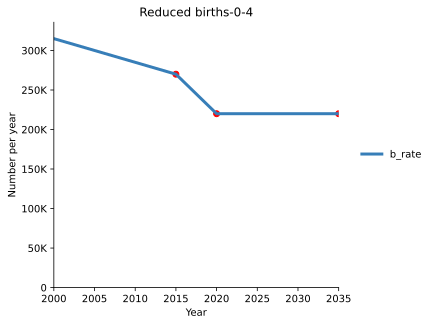

In [17]:
scvalues = dict()
scvalues['b_rate'] = dict()
scvalues['b_rate']['0-4'] = dict()
scvalues['b_rate']['0-4']["t"] = [2015, 2020, 2035]
scvalues['b_rate']['0-4']["y"] = [270000, 220000, 220000]
scen = P.make_scenario(which='parameter', name="Reduced births", scenario_values=scvalues)
res_par_scen = scen.run(P, P.parsets["default"]);

# Plot the parameter and compare to scenario input values
d = at.PlotData(res_par_scen,outputs='b_rate',pops='0-4')
at.plot_series(d)
plt.scatter(scvalues['b_rate']['0-4']["t"],scvalues['b_rate']['0-4']["y"],color='r')

### Budget scenarios

To run a program-related scenario, such as a budget or coverage scenario, it is not necessary to construct a `Scenario` object. Instead, you can directly create and use the program instructions that define the scenario:

Elapsed time for running "default": 1.23s


Elapsed time for running "default": 1.22s


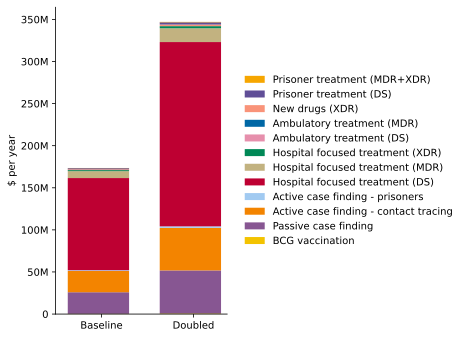

In [18]:
alloc = P.progsets[0].get_alloc(2018)
doubled_budget = {x:v*2 for x,v in alloc.items()}
instructions = at.ProgramInstructions(start_year=2018,alloc=doubled_budget)
res_baseline = P.run_sim(parset='default',progset='default',progset_instructions=at.ProgramInstructions(start_year=2018),result_name='Baseline')
res_budget_scen = P.run_sim(parset='default',progset='default',progset_instructions=instructions,result_name='Doubled');

d = at.PlotData.programs([res_baseline,res_budget_scen]).interpolate(2018)
at.plot_bars(d,stack_outputs='all');

Alternatively, you can create a full scenario object by storing the `instructions` in a `CombinedScenario`. The `CombinedScenario` optionally allows you to mix parameter and program scenarios.

Elapsed time for running "default": 1.20s


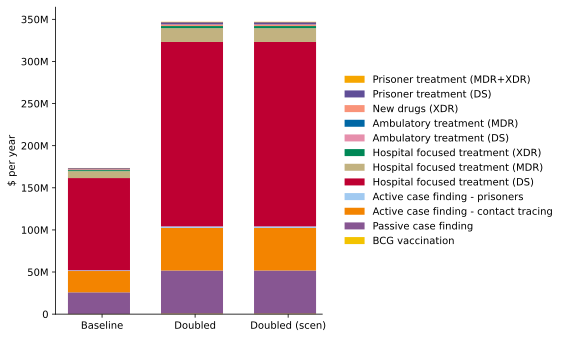

In [19]:
scen = P.make_scenario(which='combined', name="Doubled (scen)", instructions=instructions)
res_combined_scen = scen.run(P, parset='default',progset='default')

d = at.PlotData.programs([res_baseline,res_budget_scen, res_combined_scen]).interpolate(2018)
at.plot_bars(d,stack_outputs='all');

### Coverage scenarios

With coverage scenarios, the program instructions override a program's coverage. Therefore, the spending values and coverage values may not match up with what is entered in the program book. If running coverage scenarios, take care not to use the spending values for such results - typically this is not a problem, because if you did have a particular spending amount in mind, then it would be better to use a budget scenario. 

In [20]:
half_coverage = {x:0.5 for x in P.progsets[0].programs.keys()}
instructions = at.ProgramInstructions(start_year=2018,coverage=half_coverage)
scen = at.CombinedScenario(name='Reduced coverage',instructions=instructions)
res_cov_scen = scen.run(P,parset='default',progset='default');

Elapsed time for running "default": 1.44s


## Optimization

The role of optimization is to produce a set of program spending overwrites that improves the model output in some way. It is thus an operation that maps one set of program instructions to another, where the optimized program instructions contain the optimized allocation. An optimization consists of three parts

- `adjustments` that specify what parts of the program instructions to change, and how to change them
- `measurables` that define optimality (e.g. reducing new infections, maximizing people alive)
- `constraints` that must be satisfied, such as fixed total spending

An `Optimization` object contains these three items, as well any additional parameters specific to the optimization algorithm (e.g. the optimization method, the maximum run time).

The `optimize` function uses the `Optimization` to modify a particular set of program instructions. It therefore takes in

- A parset and progset to use
- A program instructions instance to optimize
- An optimization object, that specifies how to perform the optimization

In [21]:
instructions = at.ProgramInstructions(alloc=P.progsets[0],start_year=2020) # Instructions for default spending
adjustments = [at.SpendingAdjustment(x,2020,'rel',0.,2.) for x in instructions.alloc.keys()]
measurables = at.MaximizeCascadeStage(None,2020)
constraints = at.TotalSpendConstraint() # Cap total spending in all years
optimization = at.Optimization(name='default', adjustments=adjustments, measurables=measurables,constraints=constraints,maxtime=10) # Evaluate from 2020 to end of simulation
optimized_instructions = at.optimize(P, optimization, parset=P.parsets["default"], progset=P.progsets['default'], instructions=instructions)

ASD: Launching with random seed None


ASD: Warning, negative objective function starting value (-11728.9) could lead to unexpected behavior


    step=1 choice=5, par=5, pm=0.0, origval=8205000.0, newval=9025500.0
     step 1 (1.1 s) -- (orig:-11730 | best:-11730 | new:-11730 | diff:0)
ASD: Warning, negative objective function starting value (-11728.9) could lead to unexpected behavior


    step=2 choice=14, par=2, pm=1.0, origval=25282133.33333333, newval=22753919.999999996
     step 2 (2.2 s) -- (orig:-11730 | best:-11730 | new:-11730 | diff:0)
ASD: Warning, negative objective function starting value (-11728.9) could lead to unexpected behavior


    step=3 choice=3, par=3, pm=0.0, origval=893333.3333333334, newval=982666.6666666667
     step 3 (3.4 s) -- (orig:-11730 | best:-11730 | new:-11730 | diff:0)
ASD: Warning, negative objective function starting value (-11728.9) could lead to unexpected behavior


    step=4 choice=9, par=9, pm=0.0, origval=961200.0, newval=1057320.0
     step 4 (4.8 s) -- (orig:-11730 | best:-11730 | new:-11730 | diff:0)
ASD: Warning, negative objective function starting value (-11728.9) could lead to unexpected behavior


    step=5 choice=22, par=10, pm=1.0, origval=1314500.0, newval=1183050.0
     step 5 (5.9 s) -- (orig:-11730 | best:-11730 | new:-11730 | diff:0)
ASD: Warning, negative objective function starting value (-11728.9) could lead to unexpected behavior


    step=6 choice=21, par=9, pm=1.0, origval=961200.0, newval=865080.0
     step 6 (7.0 s) -- (orig:-11730 | best:-11730 | new:-11730 | diff:0)
ASD: Warning, negative objective function starting value (-11728.9) could lead to unexpected behavior


    step=7 choice=13, par=1, pm=1.0, origval=25568000.0, newval=23011200.0
     step 7 (8.2 s) -- (orig:-11730 | best:-11730 | new:-11730 | diff:0)
ASD: Warning, negative objective function starting value (-11728.9) could lead to unexpected behavior


    step=8 choice=15, par=3, pm=1.0, origval=893333.3333333334, newval=804000.0
     step 8 (9.4 s) -- (orig:-11730 | best:-11730 | new:-11730 | diff:0)
ASD: Warning, negative objective function starting value (-11728.9) could lead to unexpected behavior


    step=9 choice=18, par=6, pm=1.0, origval=1246000.0, newval=1121400.0
     step 9 (10.8 s) -- (orig:-11730 | best:-11730 | new:-11730 | diff:0)
===  Time limit reached (10.79 > 10.00) (9 steps, orig: -11730 | best: -11730 | ratio: 1.0) ===


The function returns a set of optimized instructions, that can then be used to run a simulation

In [22]:
res_optimized = P.run_sim(parset='default',progset='default',progset_instructions=optimized_instructions)

Elapsed time for running "default": 1.23s


For more details on the optimization system, see the [general documentation](https://atomica.tools/docs/master/general/Optimization.html) on optimization.